# Housing Utility LLM — Analytics Notebook

This notebook loads the ranked results CSV and produces publication-ready figures using **matplotlib only** (no seaborn, one chart per cell, no fixed colors).  
It auto-detects the CSV path from common locations.

---

## Figures included and rationale

1. **Utility decomposition (stacked bars, Top-K)**  
   Shows how total utility breaks down into:  
   - *U_base* (objective attributes: beds, baths, sqft, amenities)  
   - *U_text* (semantic similarity between buyer profile and listing description via LLM)  
   - *U_eco* (economic adjustment: budget penalty/bonus)  
   Demonstrates interpretability: we can see which component drives the recommendation.

2. **Price vs Total Utility (bubble chart, size ∝ SQFT) + Spearman correlation**  
   Highlights whether higher prices always correlate with higher utility, or if the model identifies “sweet spots” (high utility at reasonable prices).  
   Adds economic insight and validates that the ranking is not just mirroring price.

3. **Base vs Effective weights (grouped bars, mean across listings)**  
   Compares original base weights with effective weights after mood adjustments (rush, comfort, risk, urban vibe).  
   Shows adaptability: the system personalizes attribute importance dynamically from buyer text.

4. **Textual similarity vs Utility (two scatter plots + correlations)**  
   Plots semantic similarity vs. total utility for:  
   - Descriptions  
   - Personality vectors  
   Validates that the LLM-derived features actually matter, not just structured data.

5. **Pareto frontier (Utility vs Price)**  
   Identifies the efficient frontier (no option should cost more while offering less utility).  
   Connects results to multi-objective optimization and housing economics.

6. **Distribution of Utility by Neighborhood (boxplots)**  
   Shows variability of utility across neighborhoods.  
   Adds urban analysis: some neighborhoods systematically align better with the buyer profile.

7. **Geographic scatter (Top-K, LAT/LON)**  
   Maps listings geographically, colored by utility.  
   Makes the results tangible, highlighting urban clusters of high-utility listings.

8. **Simple ablation toggle (re-rank variants)**  
   Compares rankings when removing components:  
   - Without text  
   - Without economics  
   - Only base attributes  
   Critical for validation: proves that each component (attributes, LLM, economics) contributes meaningfully.

---

### Summary
These figures jointly address key reviewer questions:  
- **Interpretability** → Figures 1, 3  
- **Added value beyond trivial baselines** → Figures 4, 8  
- **Economic/urban relevance** → Figures 2, 5, 6  
- **Tangible & intuitive visualization** → Figure 7  



In [19]:

# === Cell 0: imports & CSV auto-detection ===
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Candidate CSV paths relative to this notebook's location and the repo root
CANDIDATES = [
    "ranked_results_with_llm.csv",
    "../ranked_results_with_llm.csv",
    "buyer/ranked_results_with_llm.csv",
    "../buyer/ranked_results_with_llm.csv",
    "ranked_top10_with_llm.csv",
    "../ranked_top10_with_llm.csv",
    "buyer/ranked_top10_with_llm.csv",
    "../buyer/ranked_top10_with_llm.csv",
]

CSV_PATH = None
for p in CANDIDATES:
    if os.path.exists(p):
        CSV_PATH = p
        break

if CSV_PATH is None:
    raise AssertionError("Could not find ranked_results_with_llm.csv. Please set CSV_PATH manually.")

print(f"Using CSV: {CSV_PATH}")

df = pd.read_csv(CSV_PATH)

# Cast key numeric columns safely
for col in [
    "U_total","U_base","U_text","U_eco",
    "RENT_PRICE","SQFT","sim_desc","sim_pers",
    "w_A_base","w_S_base","w_Q_base","w_N_base","w_L_base",
    "w_A_eff","w_S_eff","w_Q_eff","w_N_eff","w_L_eff",
    "LATITUDE","LONGITUDE"
]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df_sorted = df.sort_values("U_total", ascending=False).reset_index(drop=True)

# Global fig params (single-plot figures)
FIG_W, FIG_H, DPI = 7.2, 4.2, 300  # ~one-column width
TOPK = 25                            # adjust as needed

def short(s, n=24):
    s = str(s) if not (isinstance(s, float) and pd.isna(s)) else "NA"
    return s if len(s) <= n else s[:n-1] + "…"

print(f"Rows: {len(df_sorted)}, Cols: {len(df_sorted.columns)}")
df_sorted.head(2)


Using CSV: ../buyer/ranked_results_with_llm.csv
Rows: 30, Cols: 83


,ADDRESS,AVAILABILITY_STATUS,AVAILABLE_AT,BATHS,BEDS,BUILDING_TYPE,CITY,CLUBHOUSE,COMPANY,DATE_POSTED,...,U_total,tone_vector,tone_policy_flags,tone_keypoints,tone_risks,tone_social,tone_calm,tone_luxury,tone_practical,tone_urban
0,"125 Guest Street , Boston, MA 02135",available,2025-01-01 04:44:28.502,2.0,3,apartment building,Boston,0,Greystar,2025-01-01 00:00:00.000,...,1.459509,"{""social"": 0.5, ""calm"": 0.3, ""luxury"": 0.8, ""p...",{},(unspecified),NaN,0.5,0.3,0.8,0.2,0.9
1,"131 Seaport Blvd , Boston, MA 02210",available,2025-01-01 01:30:42.753,2.0,3,apartment building,Boston,1,Greystar,2025-01-01 00:00:00.000,...,1.151414,"{""social"": 0.8, ""calm"": 0.2, ""luxury"": 0.9, ""p...",{},(unspecified),NaN,0.8,0.2,0.9,0.1,0.7


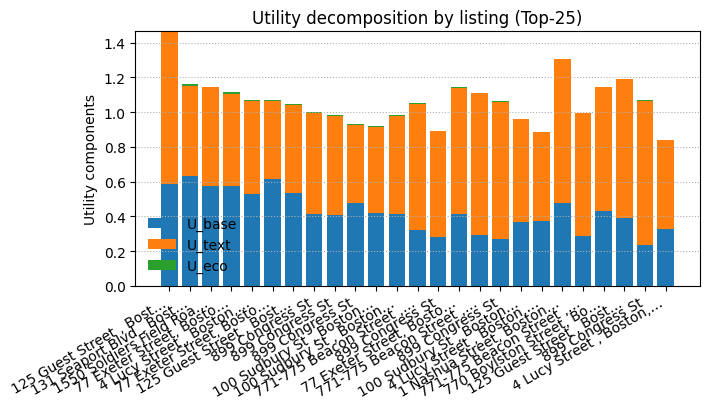

In [20]:

# === Cell 1: Utility decomposition (stacked bars, Top-K) ===
required = {"U_base","U_text","U_eco","U_total","ADDRESS"}
missing = required - set(df_sorted.columns)
assert not missing, f"Missing columns: {missing}"

top = df_sorted.head(TOPK).copy()
top["ADDRESS_SHORT"] = top["ADDRESS"].map(short)

x = np.arange(len(top))
u_base = top["U_base"].fillna(0).values
u_text = top["U_text"].fillna(0).values
u_eco  = top["U_eco"].fillna(0).values

plt.figure(figsize=(FIG_W, FIG_H))
plt.bar(x, u_base, label="U_base")
plt.bar(x, u_text, bottom=u_base, label="U_text")
plt.bar(x, u_eco,  bottom=u_base+u_text, label="U_eco")
plt.xticks(x, top["ADDRESS_SHORT"].tolist(), rotation=30, ha="right")
plt.ylabel("Utility components")
plt.title(f"Utility decomposition by listing (Top-{len(top)})")
plt.legend(frameon=False)
plt.grid(axis="y", linestyle=":", linewidth=0.8)
plt.tight_layout()
plt.show()


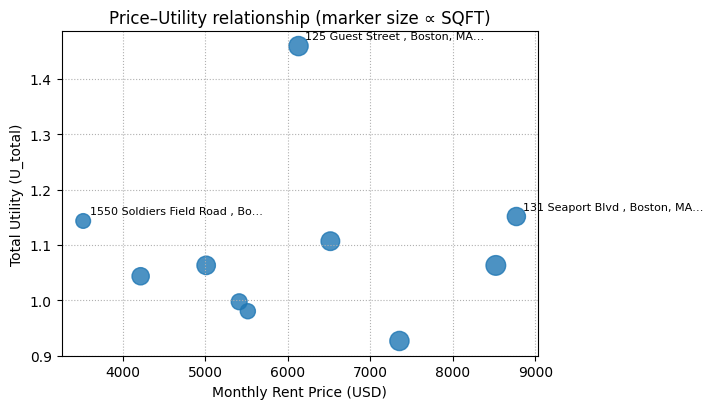

Spearman rho (price vs U_total): 0.717 (p=8.29e-06)


In [21]:

# === Cell 2: Price vs Utility (bubble ∝ SQFT) + Spearman ===
from scipy.stats import spearmanr

need = {"RENT_PRICE","U_total","SQFT","ADDRESS"}
missing = need - set(df_sorted.columns)
assert not missing, f"Missing columns: {missing}"

df_sc = df_sorted.dropna(subset=["RENT_PRICE","U_total"]).copy()
sizes = df_sc["SQFT"].fillna(df_sc["SQFT"].median())
if sizes.max() > 0:
    sizes = (sizes / sizes.max()).clip(0.2, 1.0) * 200
else:
    sizes = np.full(len(df_sc), 80.0)

plt.figure(figsize=(FIG_W, FIG_H))
plt.scatter(df_sc["RENT_PRICE"], df_sc["U_total"], s=sizes, alpha=0.8)
plt.xlabel("Monthly Rent Price (USD)")
plt.ylabel("Total Utility (U_total)")
plt.title("Price–Utility relationship (marker size ∝ SQFT)")
plt.grid(linestyle=":", linewidth=0.8)

# Annotate top-3 by utility
for _, row in df_sc.head(3).iterrows():
    plt.annotate(short(row["ADDRESS"], 30), (row["RENT_PRICE"], row["U_total"]), xytext=(5,5),
                 textcoords="offset points", fontsize=8)

plt.tight_layout()
plt.show()

rho, p = spearmanr(df_sc["RENT_PRICE"], df_sc["U_total"])
print(f"Spearman rho (price vs U_total): {rho:.3f} (p={p:.3g})")


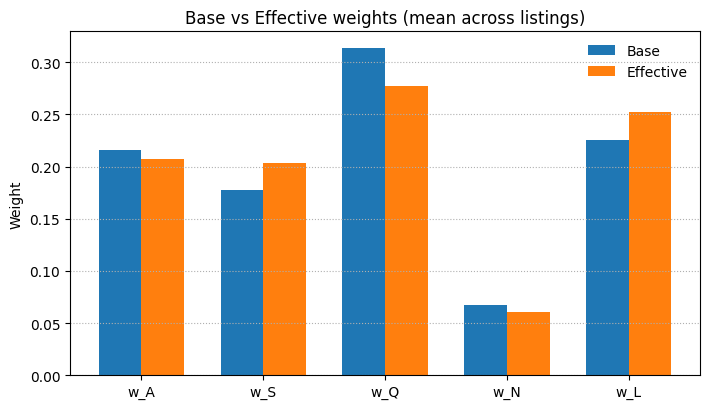

In [22]:

# === Cell 3: Base vs Effective weights (means) ===
keys = ["A","S","Q","N","L"]
need = [f"w_{k}_base" for k in keys] + [f"w_{k}_eff" for k in keys]
missing = set(need) - set(df_sorted.columns)
assert not missing, f"Missing columns: {missing}"

w_base = [df_sorted[f"w_{k}_base"].mean(skipna=True) for k in keys]
w_eff  = [df_sorted[f"w_{k}_eff"].mean(skipna=True)  for k in keys]

x = np.arange(len(keys))
width = 0.35

plt.figure(figsize=(FIG_W, FIG_H))
plt.bar(x - width/2, w_base, width, label="Base")
plt.bar(x + width/2, w_eff,  width, label="Effective")
plt.xticks(x, [f"w_{k}" for k in keys])
plt.ylabel("Weight")
plt.title("Base vs Effective weights (mean across listings)")
plt.legend(frameon=False)
plt.grid(axis="y", linestyle=":", linewidth=0.8)
plt.tight_layout()
plt.show()


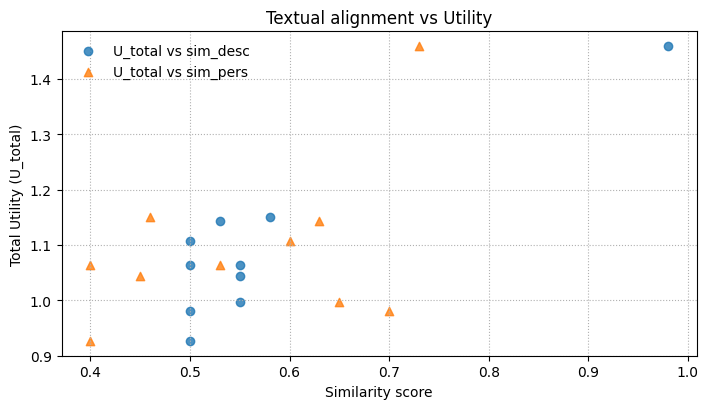

Spearman (sim_desc, U_total): rho=-0.339, p=0.0668
Spearman (sim_pers, U_total): rho=-0.053, p=0.783


In [23]:

# === Cell 4: Similarity vs Utility (two scatters) ===
from scipy.stats import spearmanr

need = {"sim_desc","sim_pers","U_total"}
missing = need - set(df_sorted.columns)
assert not missing, f"Missing columns: {missing}"

df_sim = df_sorted.dropna(subset=["U_total"]).copy()

plt.figure(figsize=(FIG_W, FIG_H))
plt.scatter(df_sim["sim_desc"], df_sim["U_total"], marker="o", alpha=0.8, label="U_total vs sim_desc")
plt.scatter(df_sim["sim_pers"], df_sim["U_total"], marker="^", alpha=0.8, label="U_total vs sim_pers")
plt.xlabel("Similarity score")
plt.ylabel("Total Utility (U_total)")
plt.title("Textual alignment vs Utility")
plt.legend(frameon=False)
plt.grid(linestyle=":", linewidth=0.8)
plt.tight_layout()
plt.show()

rho_d, p_d = spearmanr(df_sim["sim_desc"], df_sim["U_total"], nan_policy="omit")
rho_p, p_p = spearmanr(df_sim["sim_pers"], df_sim["U_total"], nan_policy="omit")
print(f"Spearman (sim_desc, U_total): rho={rho_d:.3f}, p={p_d:.3g}")
print(f"Spearman (sim_pers, U_total): rho={rho_p:.3f}, p={p_p:.3g}")


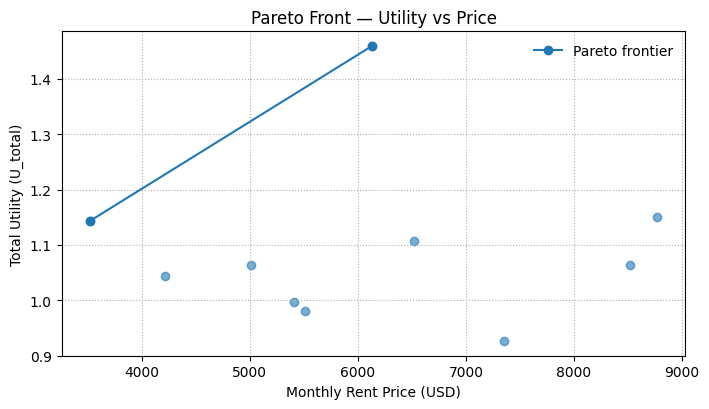

In [24]:

# === Cell 5: Pareto frontier (Utility vs Price) ===
need = {"RENT_PRICE","U_total"}
missing = need - set(df_sorted.columns)
assert not missing, f"Missing columns: {missing}"

df_p = df_sorted.dropna(subset=["RENT_PRICE","U_total"]).copy()
df_p = df_p.sort_values("RENT_PRICE", ascending=True)

pareto_idx = []
best_u = -np.inf
for i, row in df_p.iterrows():
    u = row["U_total"]
    if u >= best_u - 1e-12:
        pareto_idx.append(i)
        best_u = max(best_u, u)

plt.figure(figsize=(FIG_W, FIG_H))
plt.scatter(df_p["RENT_PRICE"], df_p["U_total"], alpha=0.6)
if pareto_idx:
    p = df_p.loc[pareto_idx]
    plt.plot(p["RENT_PRICE"], p["U_total"], marker="o", linewidth=1.5, label="Pareto frontier")
    plt.legend(frameon=False)

plt.xlabel("Monthly Rent Price (USD)")
plt.ylabel("Total Utility (U_total)")
plt.title("Pareto Front — Utility vs Price")
plt.grid(linestyle=":", linewidth=0.8)
plt.tight_layout()
plt.show()


/var/folders/ns/zbp08xns3tv2_wrm0_mdt5w80000gn/T/ipykernel_13685/1535761182.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showfliers=False)
/Users/parfait.atchade/.pyenv/versions/pennylane_env/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4781: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/Users/parfait.atchade/.pyenv/versions/pennylane_env/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/parfait.atchade/.pyenv/versions/pennylane_env/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4781: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


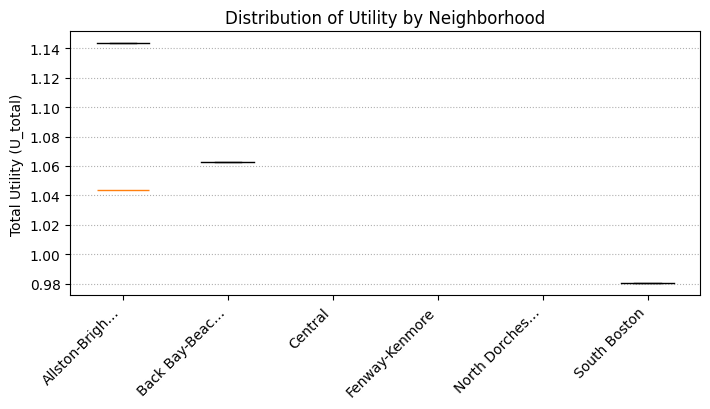

In [25]:

# === Cell 6: Utility distribution by Neighborhood (boxplots) ===
if "NEIGHBORHOOD" in df_sorted.columns:
    df_n = df_sorted.dropna(subset=["NEIGHBORHOOD","U_total"]).copy()
    if not df_n.empty:
        groups = []
        labels = []
        for name, g in df_n.groupby("NEIGHBORHOOD", sort=True):
            vals = g["U_total"].dropna().values
            if len(vals) > 0:
                groups.append(vals)
                labels.append(name if len(str(name)) <= 14 else str(name)[:13] + "…")
        if groups:
            plt.figure(figsize=(FIG_W, FIG_H))
            plt.boxplot(groups, labels=labels, showfliers=False)
            plt.xticks(rotation=45, ha="right")
            plt.ylabel("Total Utility (U_total)")
            plt.title("Distribution of Utility by Neighborhood")
            plt.grid(axis="y", linestyle=":", linewidth=0.8)
            plt.tight_layout()
            plt.show()
        else:
            print("No non-empty groups to plot.")
    else:
        print("NEIGHBORHOOD column present but all rows are NaN for plotting.")
else:
    print("NEIGHBORHOOD column not found; skipping this plot.")


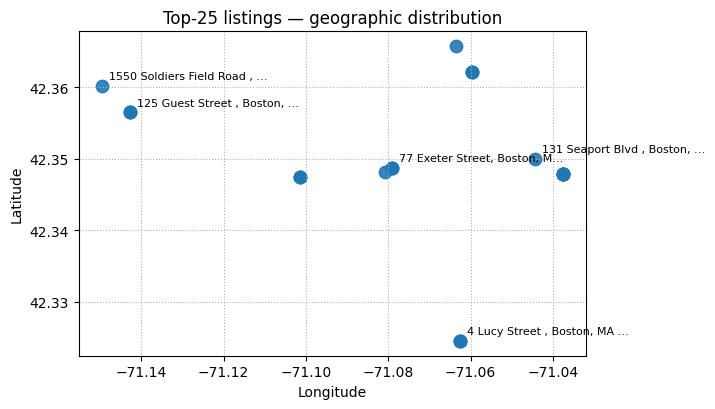

In [26]:

# === Cell 7: Geo scatter (Top-K) ===
need = {"LATITUDE","LONGITUDE","ADDRESS","U_total"}
if need.issubset(df_sorted.columns):
    top_geo = df_sorted.dropna(subset=["LATITUDE","LONGITUDE"]).head(TOPK).copy()
    if not top_geo.empty:
        plt.figure(figsize=(FIG_W, FIG_H))
        plt.scatter(top_geo["LONGITUDE"], top_geo["LATITUDE"], s=80, alpha=0.9)
        for _, r in top_geo.head(5).iterrows():
            plt.annotate(short(r["ADDRESS"], 28), (r["LONGITUDE"], r["LATITUDE"]),
                         xytext=(5,5), textcoords="offset points", fontsize=8)
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.title(f"Top-{len(top_geo)} listings — geographic distribution")
        plt.grid(linestyle=":", linewidth=0.8)
        plt.tight_layout()
        plt.show()
    else:
        print("No valid LAT/LON rows to plot.")
else:
    print(f"Missing geo columns; required: {need}")


In [27]:

# === Cell 8: Simple ablation — re-rank variants ===
need = {"U_base","U_text","U_eco","ADDRESS"}
missing = need - set(df_sorted.columns)
if not missing:
    variants = {
        "full":        (1.0, 1.0, 1.0),
        "no_text":     (1.0, 0.0, 1.0),
        "no_economy":  (1.0, 1.0, 0.0),
        "base_only":   (1.0, 0.0, 0.0),
    }
    def rerank(alpha, beta, gamma):
        s = alpha*df_sorted["U_base"].fillna(0) + beta*df_sorted["U_text"].fillna(0) + gamma*df_sorted["U_eco"].fillna(0)
        return df_sorted.assign(U_variant=s).sort_values("U_variant", ascending=False)

    results = {}
    for name, w in variants.items():
        results[name] = rerank(*w).head(10)[["ADDRESS","U_variant"]].reset_index(drop=True)
        results[name]["ADDRESS"] = results[name]["ADDRESS"].map(lambda s: s if len(str(s))<=40 else str(s)[:39]+"…")

    # Print tables
    for name in variants.keys():
        print(f"\nTop-10 — {name}")
        display(results[name])
else:
    print(f"Skipping ablation; missing columns: {missing}")



Top-10 — full


,ADDRESS,U_variant
0,"125 Guest Street , Boston, MA 02135",1.459509
1,"1 Nashua Street, Boston, MA 02114",1.304311
2,"125 Guest Street , Boston, MA 02135",1.189015
3,"131 Seaport Blvd , Boston, MA 02210",1.151414
4,"770 Boylston Street, Boston, MA 02199",1.145570
5,"131 Seaport Blvd , Boston, MA 02210",1.143648
6,"1550 Soldiers Field Road , Boston, MA 0…",1.143371
7,"77 Exeter Street, Boston, MA 02116",1.142016
8,"771-775 Beacon Street , Boston, MA 02215",1.111661
9,"790 Boylston Street, Boston, MA 02199",1.107583



Top-10 — no_text


,ADDRESS,U_variant
0,"131 Seaport Blvd , Boston, MA 02210",0.619414
1,"77 Exeter Street, Boston, MA 02116",0.603013
2,"125 Guest Street , Boston, MA 02135",0.579509
3,"1550 Soldiers Field Road , Boston, MA 0…",0.573371
4,"77 Exeter Street, Boston, MA 02116",0.566825
5,"125 Guest Street , Boston, MA 02135",0.533438
6,"4 Lucy Street , Boston, MA 02125",0.521142
7,"1 Nashua Street, Boston, MA 02114",0.474311
8,"1 Nashua Street, Boston, MA 02114",0.467112
9,899 Congress St,0.466450



Top-10 — no_economy


,ADDRESS,U_variant
0,"125 Guest Street , Boston, MA 02135",1.465795
1,"1 Nashua Street, Boston, MA 02114",1.305644
2,"125 Guest Street , Boston, MA 02135",1.190364
3,"131 Seaport Blvd , Boston, MA 02210",1.161700
4,"131 Seaport Blvd , Boston, MA 02210",1.147703
5,"770 Boylston Street, Boston, MA 02199",1.146919
6,"1550 Soldiers Field Road , Boston, MA 0…",1.145704
7,"77 Exeter Street, Boston, MA 02116",1.144618
8,"77 Exeter Street, Boston, MA 02116",1.113696
9,"771-775 Beacon Street , Boston, MA 02215",1.113319



Top-10 — base_only


,ADDRESS,U_variant
0,"131 Seaport Blvd , Boston, MA 02210",0.629700
1,"77 Exeter Street, Boston, MA 02116",0.612923
2,"125 Guest Street , Boston, MA 02135",0.585795
3,"1550 Soldiers Field Road , Boston, MA 0…",0.575704
4,"77 Exeter Street, Boston, MA 02116",0.573696
5,"125 Guest Street , Boston, MA 02135",0.536826
6,"4 Lucy Street , Boston, MA 02125",0.525733
7,"1 Nashua Street, Boston, MA 02114",0.475644
8,899 Congress St,0.474590
9,"1 Nashua Street, Boston, MA 02114",0.468355
